### Produce metadata figures

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from collections import Counter
import seaborn as sns
import scanpy as sc 
import os
import gc

In [2]:
sc._settings.settings._vector_friendly=True

In [3]:
%%time
adata = sc.read_h5ad("../07_final_RNA_without_scvi.h5ad")
adata

CPU times: user 14.6 s, sys: 1min 37s, total: 1min 51s
Wall time: 2min 31s


AnnData object with n_obs × n_vars = 2305964 × 16115
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'disease', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'barcode', 'sample_id', 'age_status', 'tech_plus_study', 'disease_binary', 'decade', 'age_group', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'scvi_cell_type', 'redo_leiden_0.5', 'UMAP1', 'UMAP2', 'v2_scvi_cell_type', 'final_cell_type'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'

In [4]:
plots_dir = "../../../paper_figures/"

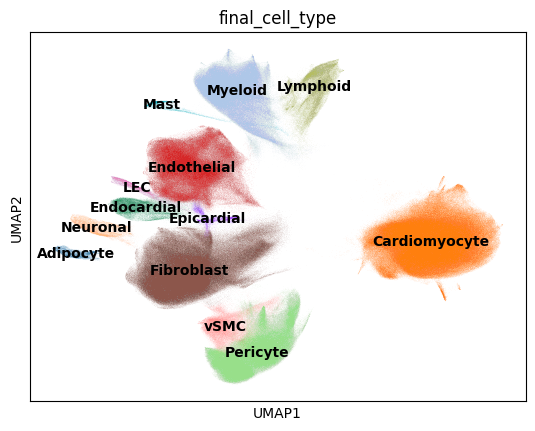

CPU times: user 22.7 s, sys: 679 ms, total: 23.4 s
Wall time: 23.1 s


In [5]:
%%time 
# create UMAP
with plt.rc_context():
    sc.pl.umap(adata, color = "final_cell_type", legend_loc = "on data", show = False)
    plt.savefig(plots_dir + "all_snRNA_UMAP.pdf", bbox_inches="tight")
    plt.show()

### Produce other UMAP plots (by study)

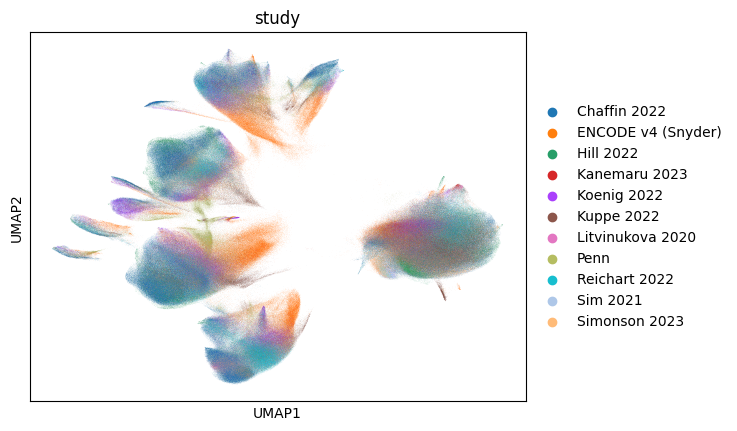

In [15]:
with plt.rc_context():
    sc.pl.umap(adata, color = "study", show = False)
    plt.savefig(plots_dir + "all_snRNA_UMAP_by_study.pdf", bbox_inches="tight")
    plt.show()

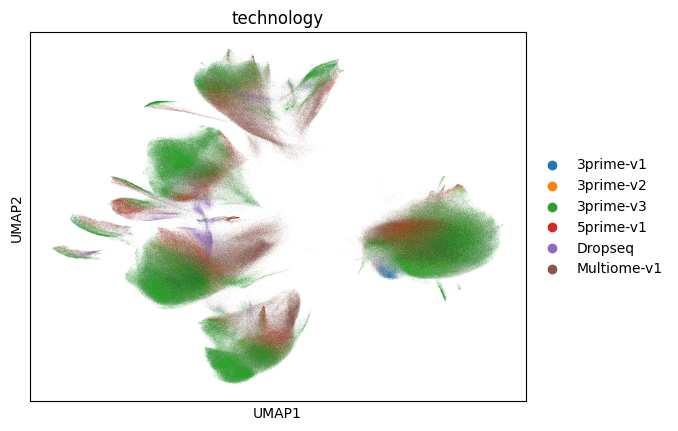

In [16]:
with plt.rc_context():
    sc.pl.umap(adata, color = "technology", show = False)
    plt.savefig(plots_dir + "all_snRNA_UMAP_by_technology.pdf", bbox_inches="tight")
    plt.show()

The original and new annotations are highly concordant. In the case of pericytes and vSMCs, some of the papers annotated them as "Mural cells", which we used as "Pericyte" for the "consistent_cell_type" annotation, which may explain why some of the annotations there are discordant.

### Create dotplot for marker gene expression

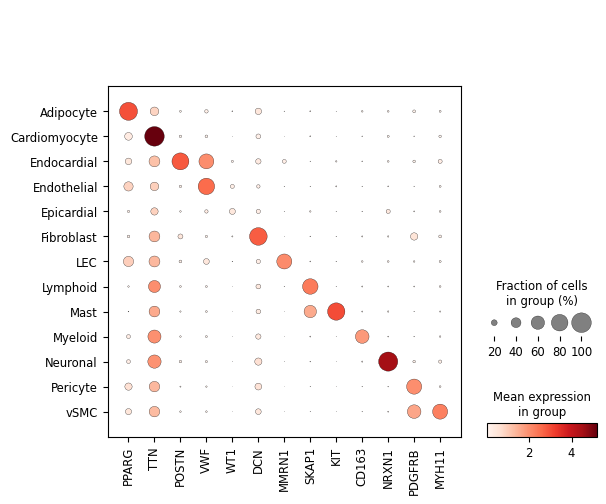

CPU times: user 11 s, sys: 6.04 s, total: 17 s
Wall time: 16.5 s


In [6]:
%%time 
marker_genes = ["PPARG", "TTN", "POSTN", "VWF", "WT1", "DCN", "MMRN1", "SKAP1", "KIT", "CD163", "NRXN1", "PDGFRB", "MYH11"]

with plt.rc_context():
    sc.pl.dotplot(adata, var_names = marker_genes, groupby = "final_cell_type", show = False)
    plt.savefig(plots_dir + "snRNA_marker_gene_dotplot.pdf", bbox_inches="tight")
    plt.show()

### Produce plots for metadata

In [7]:
donor_level_metadata = adata.obs[["age", "age_group", 
                                  "sex", "study", 
                                  "tech_plus_study", "donor_id" , "technology", 
                                 "disease_binary"]].drop_duplicates().reset_index(drop = True)

# produce plots with ggplot
#donor_level_metadata.to_csv("04_donor_level_metadata.csv")

/mnt/data1/william/tmp/ipykernel_410416/1118311750.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  donors_by_sex = donor_level_metadata.groupby('sex').count()['age'].reset_index().rename(columns = {"age": "n"})


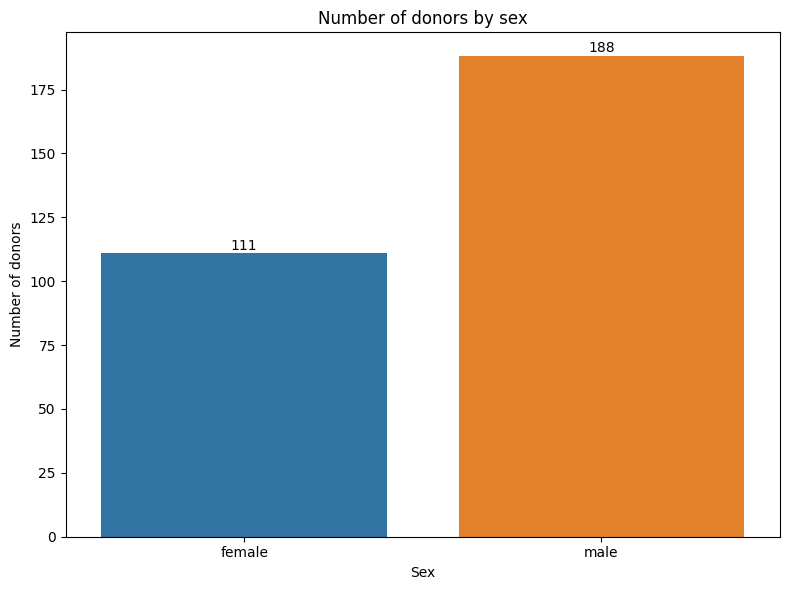

In [8]:
donors_by_sex = donor_level_metadata.groupby('sex').count()['age'].reset_index().rename(columns = {"age": "n"})

# Set up the figure size
plt.figure(figsize=(8, 6))

# Create the vertical bar plot
sns.barplot(data=donors_by_sex, x='sex', y='n', hue='sex', dodge=False)

# Add the values on top of the bars
for index, value in enumerate(donors_by_sex['n']):
    plt.text(index, value * 1.01, str(value), ha='center')  # Adjusted to display values above the bars

# Add labels and title
plt.xlabel('Sex')
plt.ylabel('Number of donors')
plt.title('Number of donors by sex')

# Show the plot
plt.tight_layout()
plt.savefig(plots_dir + "snRNA_donor_sex_barplot.pdf")
plt.show()

### Number of cells per cell type based on disease and postnatal status

In [9]:
adata_metadata = adata.obs

adata_metadata['combined_disease_age_status'] = ( adata_metadata['age_status'].astype(str) + "_" +
                                                 adata_metadata['disease_binary'].astype(str) )

In [10]:
# group by final cell type + disease/age status
#cell_type_df = adata_metadata.groupby(["final_cell_type", "combined_disease_age_status"]).count().reset_index(drop = False)
#cell_type_df = cell_type_df[['final_cell_type', 'combined_disease_age_status', 'age']].rename(columns = {'age': 'count'})

In [11]:
# group by final cell type only
cell_type_df = adata_metadata.groupby(["final_cell_type"]).count().reset_index(drop = False)
cell_type_df = cell_type_df[['final_cell_type', 'age']].rename(columns = {'age': 'count'}).sort_values(by = "count", ascending=False)

# make the cell type a string so that the order isn't fixed
cell_type_df.final_cell_type = cell_type_df.final_cell_type.astype(str)

print(cell_type_df)

print(cell_type_df['count'].sum())

/mnt/data1/william/tmp/ipykernel_410416/1810838434.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_df = adata_metadata.groupby(["final_cell_type"]).count().reset_index(drop = False)


   final_cell_type   count
1    Cardiomyocyte  676654
5       Fibroblast  548613
3      Endothelial  317124
11        Pericyte  281784
9          Myeloid  241337
7         Lymphoid   69128
12            vSMC   59357
2      Endocardial   42582
10        Neuronal   22613
6              LEC   13723
0        Adipocyte   12098
4       Epicardial   11993
8             Mast    8958
2305964


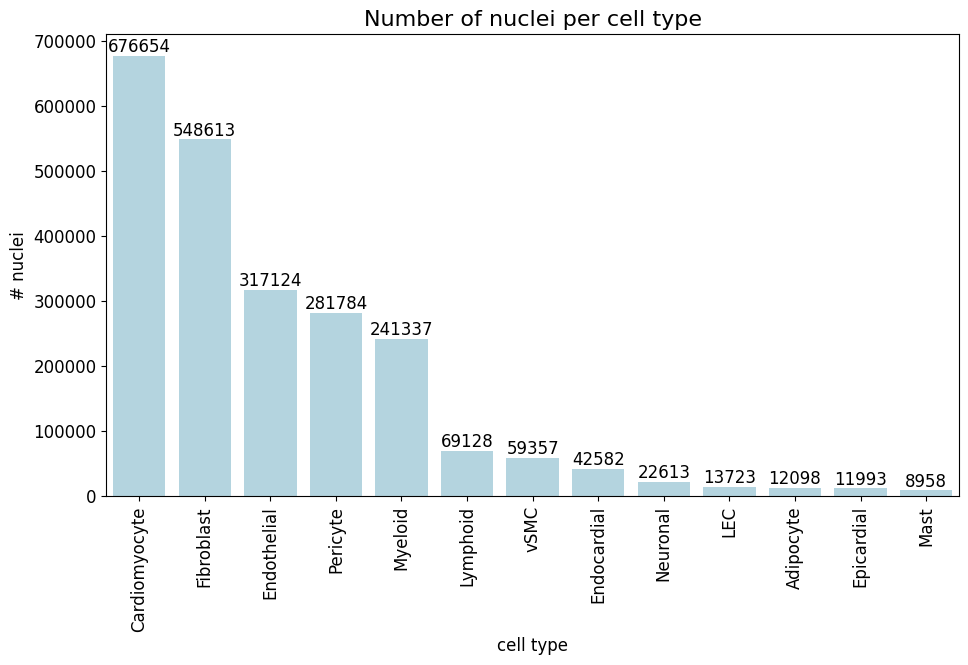

In [13]:
plt.figure(figsize=(11, 6))
sns.barplot(data = cell_type_df, x = 'final_cell_type', y = 'count', color = 'lightblue')

plt.xticks(rotation = 90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("cell type", fontsize = 12)
plt.ylabel("# nuclei", fontsize = 12)
plt.title("Number of nuclei per cell type", fontsize = 16)

for p in plt.gca().patches:
    plt.text(
        p.get_x() + p.get_width() / 2,  
        p.get_height(),                 
        f'{int(p.get_height())}',      
        ha='center',                   
        va='bottom',                    
        fontsize=12                     
    )

#plt.legend(title='status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(plots_dir + "snRNA_seq_num_cells_per_cell_type.pdf")
plt.show()